# Final Project

**Team Members: Zain Ali, Ben Hopwood, and Hallie Kinsey**

In [ ]:
import math
import random
import warnings

import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import ttest_ind, chi2_contingency, ks_2samp
import seaborn as sns
import xgboost as xgb
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from IPython.display import display, Markdown

from sklearn.impute import SimpleImputer
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_curve, roc_auc_score, classification_report, auc, accuracy_score
)
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [ ]:
# System Settings
plt.style.use('_classic_test_patch')

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Acquisition and Cleaning

### Data Source Description: Heart Disease Dataset

**Overview:**
The Heart Disease dataset is a comprehensive collection of patient data aimed at understanding the presence of heart disease. While the dataset encompasses 76 attributes, the majority of published research has utilized a subset of 14 primary attributes. The primary focus of studies using this dataset has been to distinguish between the presence and absence of heart disease.

**Dataset Specifics:**
- **Total Attributes:** 76
- **Attributes Used in Studies:** 14
- **Primary Goal:** To identify the presence (values 1,2,3,4) or absence (value 0) of heart disease in patients.
- **Missing Values:** Yes, specific attributes with missing values are highlighted in the variables table below.
- **Database Version:** The Cleveland database version is primarily used in machine learning research. It has been processed, and patient-identifying information like names and social security numbers have been replaced with dummy values.
- **Additional Resources:** Test costs associated with this dataset have been donated by Peter Turney and can be found in the "Costs" folder.

**Publication Reference:**
Detrano, R., Jánosi, A., Steinbrunn, W., Pfisterer, M., Schmid, J., Sandhu, S., Guppy, K., Lee, S., & Froelicher, V. (1989). International application of a new probability algorithm for the diagnosis of coronary artery disease. *American Journal of Cardiology*.

**Variables Table:**

| Variable Name | Role          | Type         | Demographic                                         | Description                                                     | Units   | Missing Values |
|---------------|---------------|--------------|-----------------------------------------------------|-----------------------------------------------------------------|---------|----------------|
| age           | Feature       | Integer     | Age                                                 | -                                                               | years   | no             |
| sex           | Feature       | Categorical | Sex                                                 | -                                                               | -       | no             |
| cp            | Feature       | Categorical | -                                                   | -                                                               | -       | no             |
| trestbps      | Feature       | Integer     | -                                                   | Resting blood pressure (on admission to the hospital)           | mm Hg   | no             |
| chol          | Feature       | Integer     | -                                                   | Serum cholesterol                                               | mg/dl   | no             |
| fbs           | Feature       | Categorical | -                                                   | Fasting blood sugar > 120 mg/dl                                 | -       | no             |
| restecg       | Feature       | Categorical | -                                                   | -                                                               | -       | no             |
| thalach       | Feature       | Integer     | -                                                   | Maximum heart rate achieved                                     | -       | no             |
| exang         | Feature       | Categorical | -                                                   | Exercise induced angina                                         | -       | no             |
| oldpeak       | Feature       | Integer     | -                                                   | ST depression induced by exercise relative to rest              | -       | no             |
| slope         | Feature       | Categorical | -                                                   | -                                                               | -       | no             |
| ca            | Feature       | Integer     | -                                                   | Number of major vessels (0-3) colored by fluoroscopy            | -       | yes            |
| thal          | Feature       | Categorical | -                                                   | -                                                               | -       | yes            |
| num           | Target        | Integer     | -                                                   | Diagnosis of heart disease                                      | -       | no             |

---

**Dataset Link:** [Heart Disease Dataset - UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/45/heart+disease)

### Importing Data

In [ ]:
# Paths and column names for data loading
drive_path = ""
files = [
    'processed.cleveland.data',
    'processed.switzerland.data',
    'processed.va.data',
    'reprocessed.hungarian.data'
]
column_names = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
    'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'
]

# Initialize mappings for locations
location_mapping = {}
location_counter = 1
data_per_location = {}

# Process each file and map to a unique location number
for file_url in files:
    full_file_url = drive_path + file_url
    location_name = file_url.split('/')[-1].split('.')[1]
    if location_name not in location_mapping:
        location_mapping[location_name] = location_counter
        location_counter += 1
    df = pd.read_csv(
        full_file_url, sep='[, ]', names=column_names,
        engine='python', na_values='?'
    )
    df['location'] = location_mapping[location_name]
    data_per_location[location_name] = df

# Combine data from all locations into one DataFrame
data = pd.concat(data_per_location.values(), ignore_index=True)
# Creating unclean data for later questions
unclean_data = data.copy()

### Preliminary Data Exploration

In [ ]:
print('Data Info')
display(data.info())

print('Data Head')
display(data.head())

print('Data Describe')
display(data.describe())

print("Data Types")
display(data.dtypes)

Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    float64
 1   sex       920 non-null    float64
 2   cp        920 non-null    float64
 3   trestbps  862 non-null    float64
 4   chol      913 non-null    float64
 5   fbs       838 non-null    float64
 6   restecg   919 non-null    float64
 7   thalach   866 non-null    float64
 8   exang     866 non-null    float64
 9   oldpeak   858 non-null    float64
 10  slope     801 non-null    float64
 11  ca        600 non-null    float64
 12  thal      700 non-null    float64
 13  num       920 non-null    int64  
 14  location  920 non-null    int64  
dtypes: float64(13), int64(2)
memory usage: 107.9 KB


None

Data Head


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,location
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,1
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,1
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,1


Data Describe


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,location
count,920.000000,920.000000,920.000000,862.000000,913.000000,838.000000,919.000000,866.000000,866.000000,858.000000,801.000000,600.000000,700.000000,920.000000,920.000000
mean,53.510870,0.789130,3.250000,131.968677,193.887185,0.078759,0.594124,137.376443,0.378753,0.878788,-0.784020,-3.986667,-0.265714,1.133696,2.527174
std,9.424685,0.408148,0.930969,19.651971,114.139483,0.965846,0.865464,26.385477,0.582767,1.091226,4.616226,4.910874,7.007515,1.258942,1.244496
min,28.000000,0.000000,1.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-2.600000,-9.000000,-9.000000,-9.000000,0.000000,1.000000
25%,47.000000,1.000000,3.000000,120.000000,167.000000,0.000000,0.000000,120.000000,0.000000,0.000000,1.000000,-9.000000,-9.000000,0.000000,1.000000
50%,54.000000,1.000000,4.000000,130.000000,222.000000,0.000000,0.000000,140.000000,0.000000,0.500000,2.000000,0.000000,3.000000,1.000000,3.000000
75%,60.000000,1.000000,4.000000,140.000000,267.000000,0.000000,1.000000,157.000000,1.000000,1.500000,2.000000,0.000000,7.000000,2.000000,4.000000
max,77.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,9.000000,7.000000,4.000000,4.000000


Data Types


age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca          float64
thal        float64
num           int64
location      int64
dtype: object

### Cleaning and Adding Context to Data

In [ ]:
# Adding Metadata
column_metadata = {
    'age': {
        'Role': 'Feature',
        'Type': 'Integer',
        'Demographic': 'Age',
        'Description': 'age in years',
        'Units': 'years',
    },
    'sex': {
        'Role': 'Feature',
        'Type': 'Categorical',
        'Demographic': 'Sex',
        'Description': 'sex (1 = male; 0 = female)',
        'Units': '',
    },
    'cp': {
        'Role': 'Feature',
        'Type': 'Categorical',
        'Demographic': '',
        'Description': 'chest pain type',
        'Units': '',
    },
    'trestbps': {
        'Role': 'Feature',
        'Type': 'Integer',
        'Demographic': '',
        'Description': 'resting blood pressure (in mm Hg on admission to the hospital)',  # noqa: E501
        'Units': 'mm Hg',
    },
    'chol': {
        'Role': 'Feature',
        'Type': 'Integer',
        'Demographic': '',
        'Description': 'serum cholestoral in mg/dl',
        'Units': 'mg/dl',
    },
    'fbs': {
        'Role': 'Feature',
        'Type': 'Categorical',
        'Demographic': '',
        'Description': 'fasting blood sugar > 120 mg/dl (1 = true; 0 = false)',
        'Units': '',
    },
    'restecg': {
        'Role': 'Feature',
        'Type': 'Categorical',
        'Demographic': '',
        'Description': 'resting electrocardiographic results',
        'Units': '',
    },
    'thalach': {
        'Role': 'Feature',
        'Type': 'Integer',
        'Demographic': '',
        'Description': 'maximum heart rate achieved',
        'Units': '',
    },
    'exang': {
        'Role': 'Feature',
        'Type': 'Categorical',
        'Demographic': '',
        'Description': 'exercise induced angina (1 = yes; 0 = no)',
        'Units': '',
    },
    'oldpeak': {
        'Role': 'Feature',
        'Type': 'Integer',
        'Demographic': '',
        'Description': 'ST depression induced by exercise relative to rest',
        'Units': '',
    },
    'slope': {
        'Role': 'Feature',
        'Type': 'Categorical',
        'Demographic': '',
        'Description': 'the slope of the peak exercise ST segment',
        'Units': '',
    },
    'ca': {
        'Role': 'Feature',
        'Type': 'Integer',
        'Demographic': '',
        'Description': 'number of major vessels (0-3) colored by flourosopy',
        'Units': '',
    },
    'thal': {
        'Role': 'Feature',
        'Type': 'Categorical',
        'Demographic': '',
        'Description': '3 = normal; 6 = fixed defect; 7 = reversable defect',
        'Units': '',
    },
    'num': {
        'Role': 'Target',
        'Type': 'Integer',
        'Demographic': '',
        'Description': 'diagnosis of heart disease (angiographic disease status)',  # noqa: E501
        'Units': '',
    },
    'location': {
        'Role': 'Metadata',
        'Type': 'Metadata',
        'Demographic': '',
        'Description': 'Dataset location (' + '; '.join(f'{num} = {name}' for name, num in location_mapping.items()) + ')',  # noqa: E501
        'Units': '',
    }
}


data.attrs['column_metadata'] = column_metadata

In [ ]:
# Suggested new column names based on descriptions
new_column_names = {
    'age': 'Age',
    'sex': 'Sex',
    'cp': 'ChestPain',
    'trestbps': 'RestBP',
    'chol': 'Chol',
    'fbs': 'FBS',
    'restecg': 'RestECG',
    'thalach': 'MaxHeartRate',
    'exang': 'ExAngina',
    'oldpeak': 'STDepression',
    'slope': 'STSlope',
    'ca': 'VesselsCount',
    'thal': 'ThalType',
    'num': 'HeartDisease'
}

# Update the column_metadata with new column names and add "data_name" key
updated_column_metadata = {}
for old_name, new_name in new_column_names.items():
    updated_column_metadata[new_name] = column_metadata[old_name]
    updated_column_metadata[new_name]['data_name'] = old_name

data.rename(columns=new_column_names, inplace=True)

In [ ]:
print(data.isnull().sum())

Age               0
Sex               0
ChestPain         0
RestBP           58
Chol              7
FBS              82
RestECG           1
MaxHeartRate     54
ExAngina         54
STDepression     62
STSlope         119
VesselsCount    320
ThalType        220
HeartDisease      0
location          0
dtype: int64


In [ ]:
# Uncomment if need to go back and re-configure the data to the uncleaned data.
# data = unclean_data

In [ ]:
# Clean the data
data = data.replace("?", np.nan)

# Impute missing values
imputer = SimpleImputer(strategy='median')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
print("Data That is null after imputation: \n")
print(data_imputed.isnull().sum())

Data That is null after imputation: 

Age             0
Sex             0
ChestPain       0
RestBP          0
Chol            0
FBS             0
RestECG         0
MaxHeartRate    0
ExAngina        0
STDepression    0
STSlope         0
VesselsCount    0
ThalType        0
HeartDisease    0
location        0
dtype: int64


In [ ]:
# Change strings to floats
columns_to_convert = [
    new_column_names[x] for x in [
        'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
        'exang', 'oldpeak', 'slope', 'ca', 'thal'
    ]
]

for column in columns_to_convert:
    data[column] = pd.to_numeric(data[column], errors='coerce')

# Mean imputation
for column in columns_to_convert:
    data[column].fillna(data[column].mean(), inplace=True)

## Exploratory Data Analysis

### Data Distribution

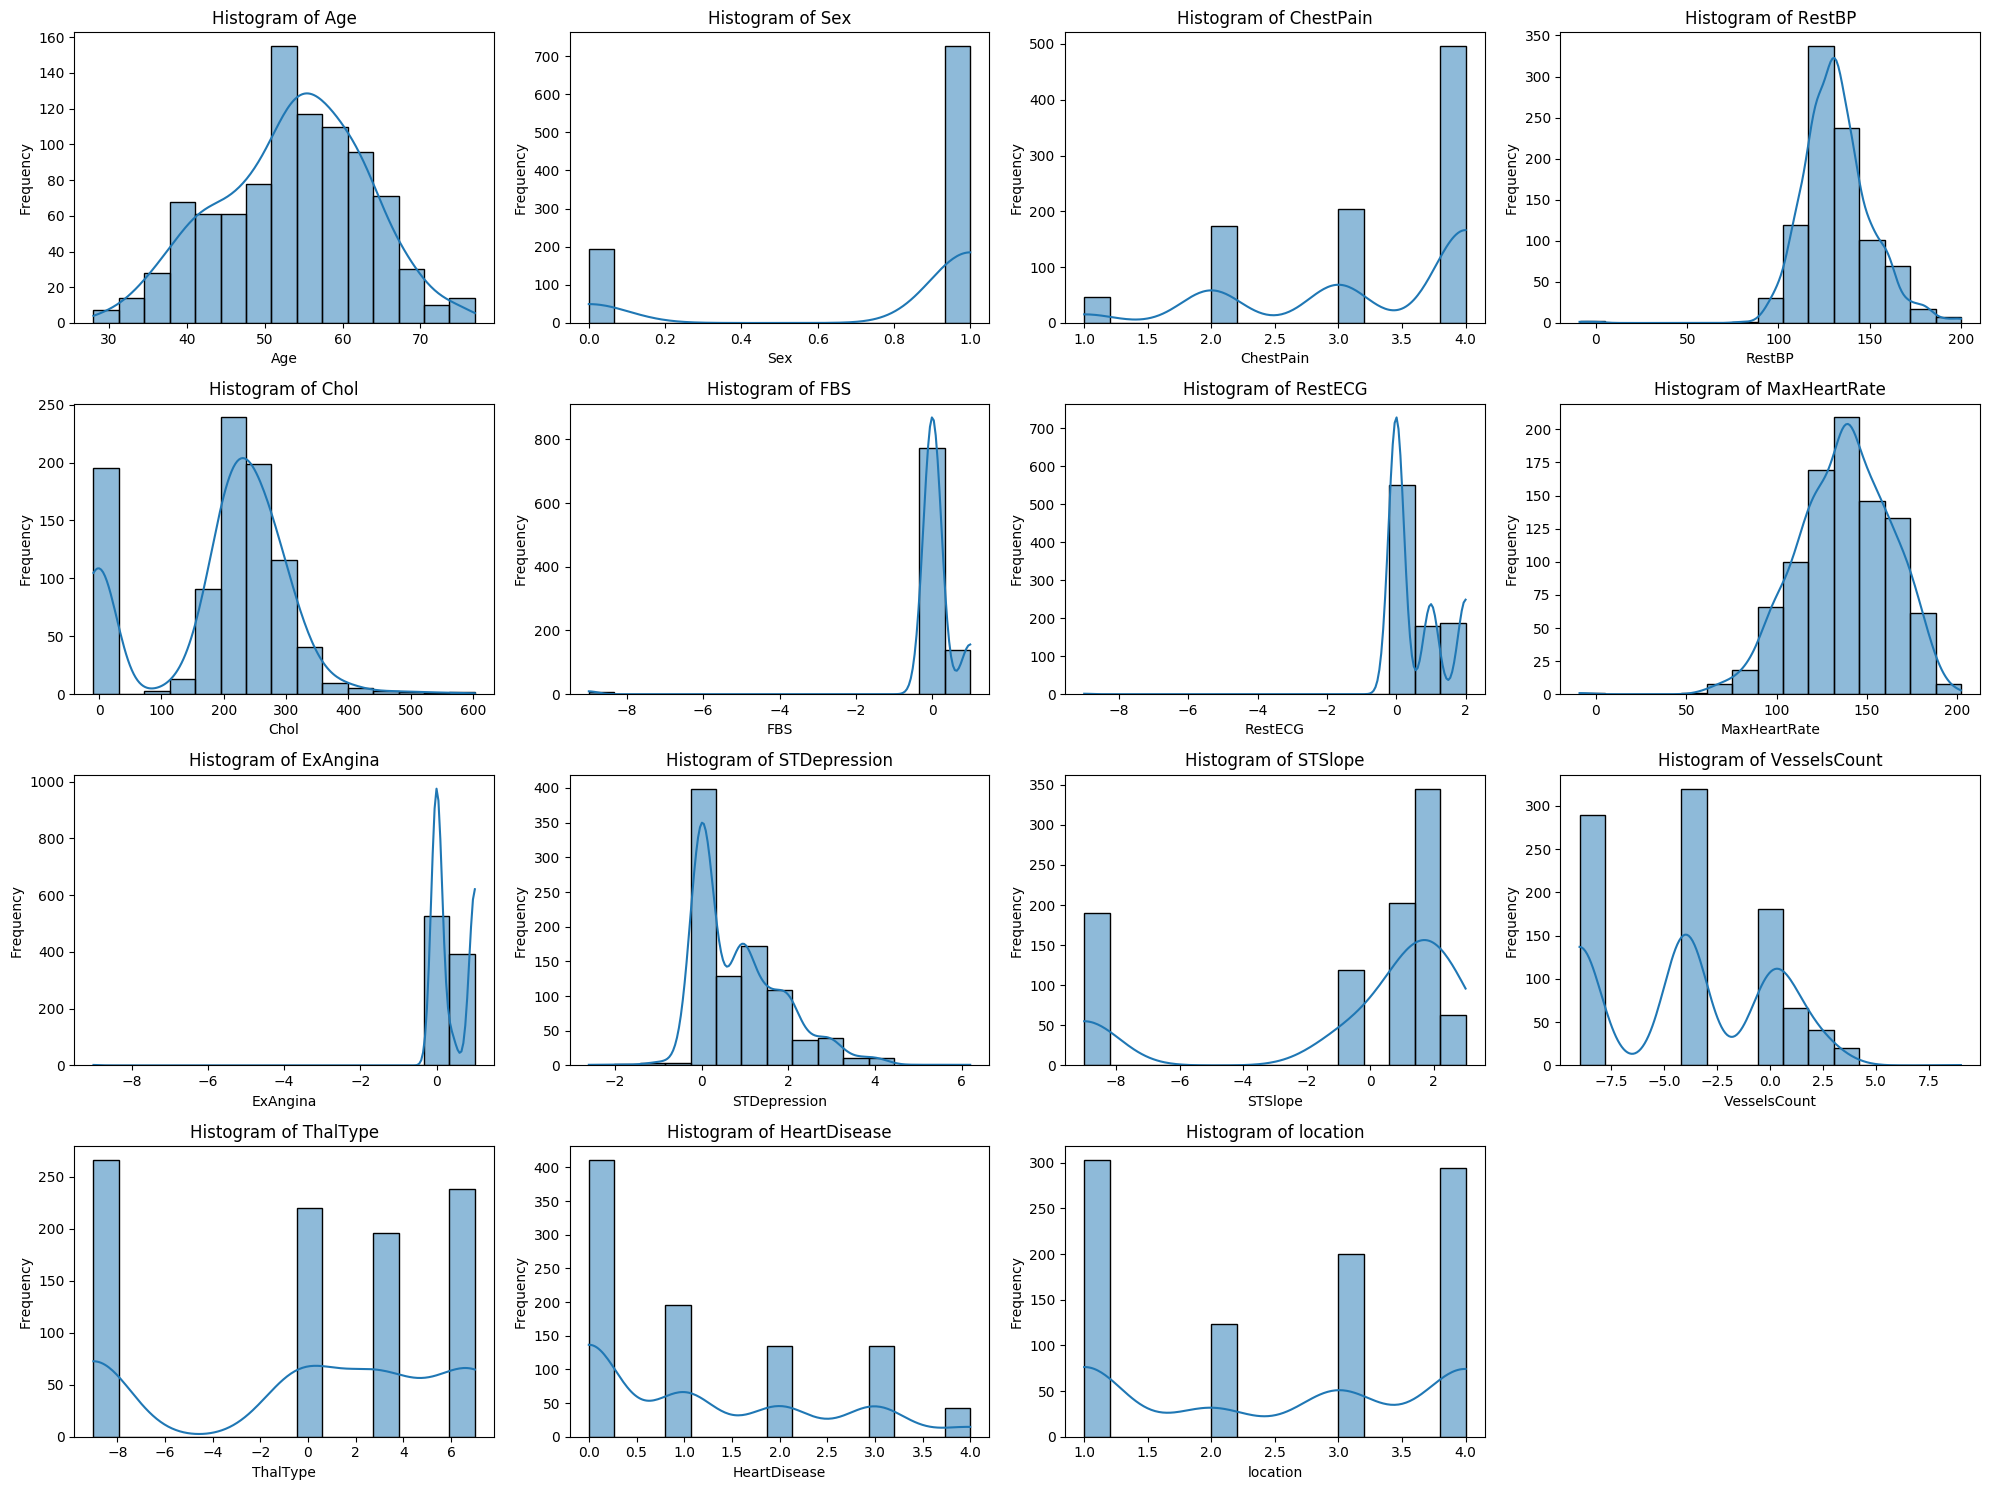

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 15))
for idx, col in enumerate(data.columns, 1):
    plt.subplot(4, 4, idx)
    try:
        # Try to plot a histogram
        sns.histplot(data[col], bins=15, kde=True)
    except TypeError:
        # If there's a TypeError, plot a vertical countplot instead
        sns.countplot(x=data[col])
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Histograms were used to inspect the initial distribution of the variables, look for extreme outliers and gain a better understanding of our variables as a whole.

### Correlation Analysis

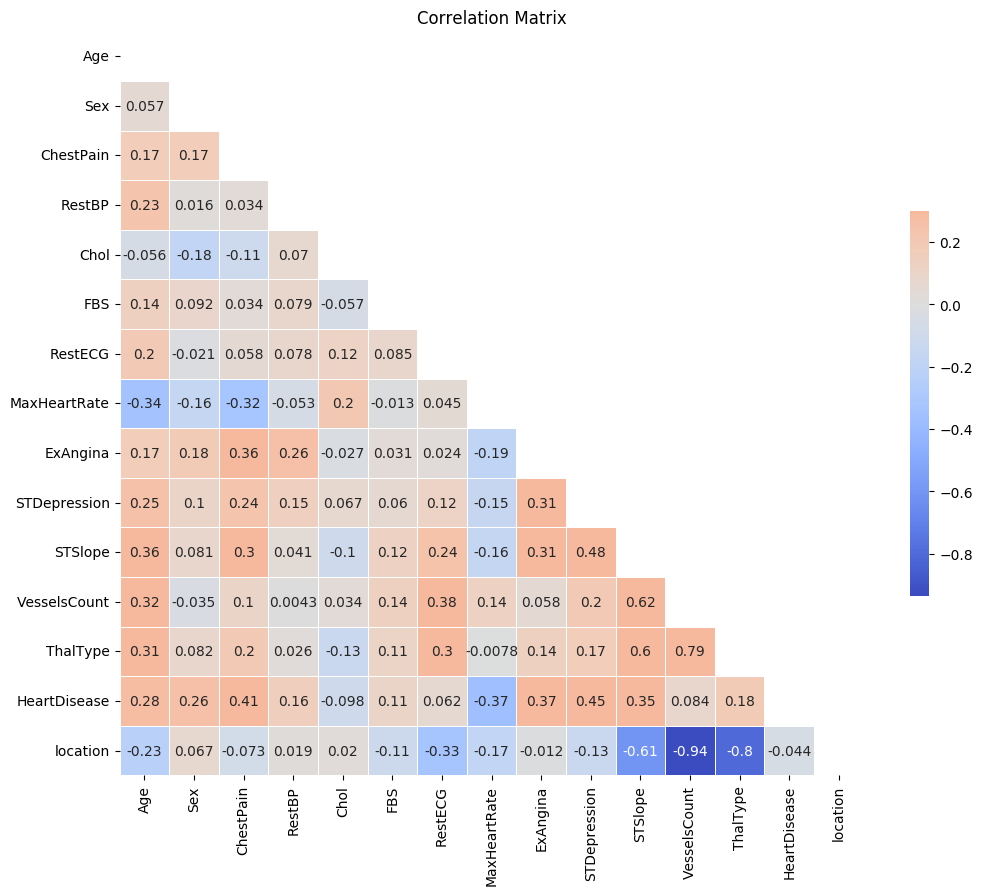

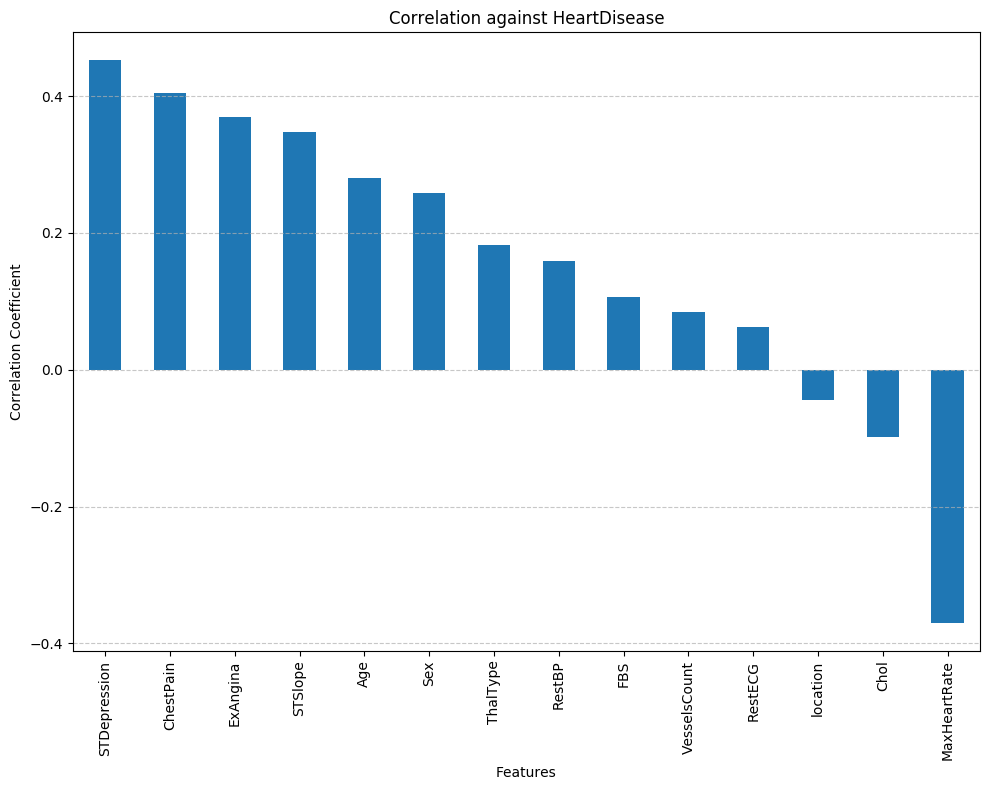

In [ ]:
def plot_correlation_matrix(data, figsize=(12, 10), cmap='coolwarm', vmax=0.3):
    corr_matrix = data.corr()

    # Mask upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    plt.figure(figsize=figsize)

    # Draw Heatmap
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=vmax, center=0,
                square=True, linewidths=.5, annot=True,
                cbar_kws={"shrink": .5})

    plt.title('Correlation Matrix')
    plt.show()


def plot_correlation_against_y(data, y_column=new_column_names['num'], ax=None,
                               figsize=(10, 8), Note=""):
    # Calculate correlation against y_column
    correlations = data.corr()[y_column].drop(y_column)
    # If ax is None, create a new figure and axis
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)
    # Plotting
    correlations.sort_values(ascending=False).plot(kind='bar', ax=ax)
    col_name = "Heart Disease" if y_column == 'num' else y_column
    title = f'Correlation against {col_name}' if not Note else Note
    ax.set_title(title)
    ax.set_ylabel('Correlation Coefficient')
    ax.set_xlabel('Features')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()


# Correlation Matrices
plot_correlation_matrix(data)
plot_correlation_against_y(data)

### Model Comparison

In [ ]:
# Model comparison
X = data.drop(new_column_names["num"], axis=1)
y = data[new_column_names["num"]].copy()
y.loc[y != 0] = 1


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# XGBoost
xg_clf = xgb.XGBClassifier(objective="binary:logistic",
                           n_estimators=100, seed=42)
xg_clf.fit(X_train, y_train)

# Neural Network (MLP)
mlp = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    max_iter=500,
    alpha=1e-4,
    solver="sgd",
    verbose=10,
    random_state=42,
    learning_rate_init=0.1,
)
mlp.fit(X_train, y_train)

# Logistic Regression
log_reg = LogisticRegression(max_iter=5000)
log_reg.fit(X_train, y_train)

# Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Gradient Boosting
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_clf.fit(X_train, y_train)

# Model Accuracy
knn_accuracy = knn.score(X_test, y_test)
xg_accuracy = xg_clf.score(X_test, y_test)
mlp_accuracy = mlp.score(X_test, y_test)
log_reg_accuracy = log_reg.score(X_test, y_test)
rf_accuracy = rf_clf.score(X_test, y_test)
gb_accuracy = gb_clf.score(X_test, y_test)

Iteration 1, loss = 30.54109624
Iteration 2, loss = 77105606.38280593
Iteration 3, loss = 232257577.52248648
Iteration 4, loss = 383323235.94073886
Iteration 5, loss = 3720291394019478.50000000
Iteration 6, loss = 16066029576534338.00000000
Iteration 7, loss = 29154281974702076.00000000
Iteration 8, loss = 39934820254682048.00000000
Iteration 9, loss = 47952036443948720.00000000
Iteration 10, loss = 53618482183655872.00000000
Iteration 11, loss = 57515006601388096.00000000
Iteration 12, loss = 60157130838241160.00000000
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


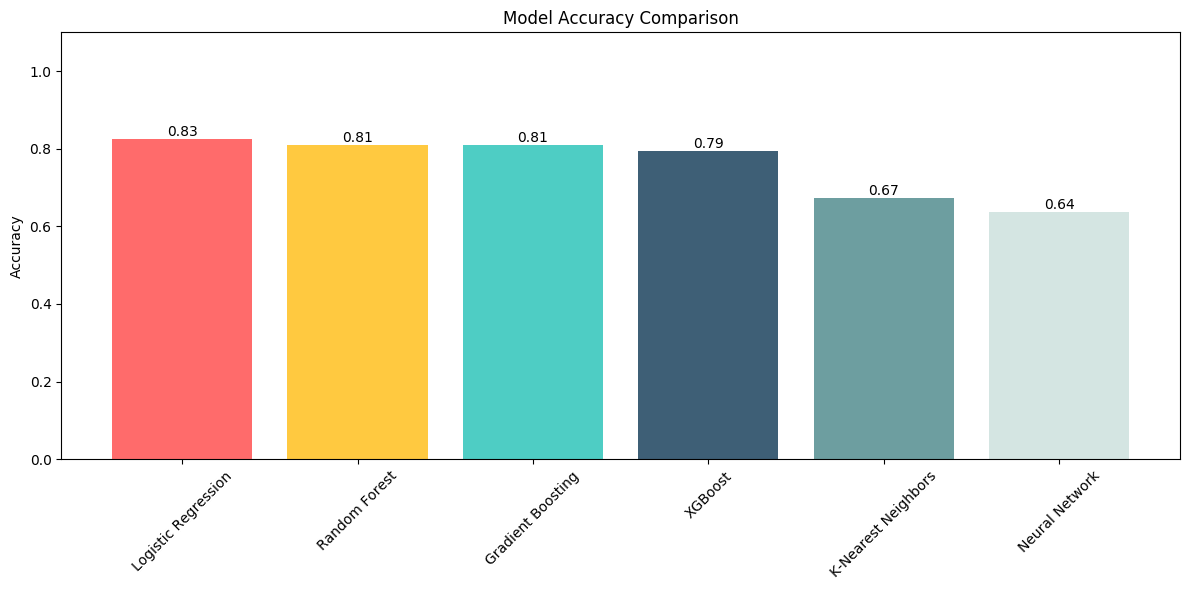

In [ ]:
# Create a dictionary with models as keys and accuracies as values
accuracy_dict = {
    "K-Nearest Neighbors": knn_accuracy,
    "XGBoost": xg_accuracy,
    "Neural Network": mlp_accuracy,
    "Logistic Regression": log_reg_accuracy,
    "Random Forest": rf_accuracy,
    "Gradient Boosting": gb_accuracy,
}

# Sort the dictionary by accuracy in descending order
sorted_accuracy = sorted(accuracy_dict.items(),
                         key=lambda x: x[1], reverse=True)

# Extract sorted models and accuracies for plotting
sorted_models = [item[0] for item in sorted_accuracy]
sorted_accuracies = [item[1] for item in sorted_accuracy]

# Use the given color scheme for plotting
colors = ["#FF6B6B", "#FFC940", "#4ECDC4", "#3E5F76", "#6D9EA0", "#D4E5E2"]

# Plotting
plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_models, sorted_accuracies, color=colors)

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.2f}",
        ha="center",
        va="bottom",
    )

plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim([0, 1.1])  # Adjusted to allow space for the text
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

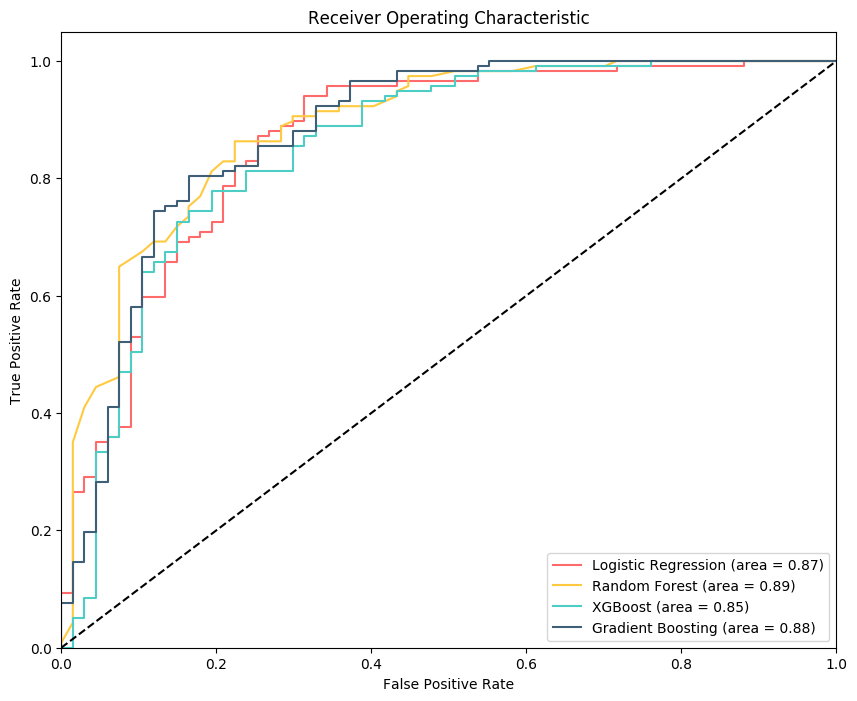

In [ ]:
# Initialize dictionaries for ROC curve data
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC and AUC for Logistic Regression
y_score_lr = log_reg.predict_proba(X_test)[:, 1]
fpr["Logistic Regression"], tpr["Logistic Regression"], _ = roc_curve(
    y_test, y_score_lr
)
roc_auc["Logistic Regression"] = auc(
    fpr["Logistic Regression"], tpr["Logistic Regression"]
)

# Compute ROC and AUC for Random Forest
y_score_rf = rf_clf.predict_proba(X_test)[:, 1]
fpr["Random Forest"], tpr["Random Forest"], _ = roc_curve(y_test, y_score_rf)
roc_auc["Random Forest"] = auc(fpr["Random Forest"], tpr["Random Forest"])

# Compute ROC and AUC for Gradient Boosting
y_score_gb = gb_clf.predict_proba(X_test)[:, 1]
fpr["Gradient Boosting"], tpr["Gradient Boosting"], _ = roc_curve(y_test,
                                                                  y_score_gb)
roc_auc["Gradient Boosting"] = auc(fpr["Gradient Boosting"],
                                   tpr["Gradient Boosting"])

# Compute ROC and AUC for XGBoost
y_score_xgb = xg_clf.predict_proba(X_test)[:, 1]
fpr["XGBoost"], tpr["XGBoost"], _ = roc_curve(y_test, y_score_xgb)
roc_auc["XGBoost"] = auc(fpr["XGBoost"], tpr["XGBoost"])


# Plot ROC curve for all three models
plt.figure(figsize=(10, 8))
plt.plot(
    fpr["Logistic Regression"],
    tpr["Logistic Regression"],
    label=f'Logistic Regression (area = {roc_auc["Logistic Regression"]:.2f})',
    color=colors[0],
)
plt.plot(
    fpr["Random Forest"],
    tpr["Random Forest"],
    label=f'Random Forest (area = {roc_auc["Random Forest"]:.2f})',
    color=colors[1],
)
plt.plot(
    fpr["XGBoost"],
    tpr["XGBoost"],
    label=f'XGBoost (area = {roc_auc["XGBoost"]:.2f})',
    color=colors[2],
)
plt.plot(
    fpr["Gradient Boosting"],
    tpr["Gradient Boosting"],
    label=f'Gradient Boosting (area = {roc_auc["Gradient Boosting"]:.2f})',
    color=colors[3],
)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

`With an AUC score of 0.87, it means the model is very good at distinguishing between those with heart disease and those without.`

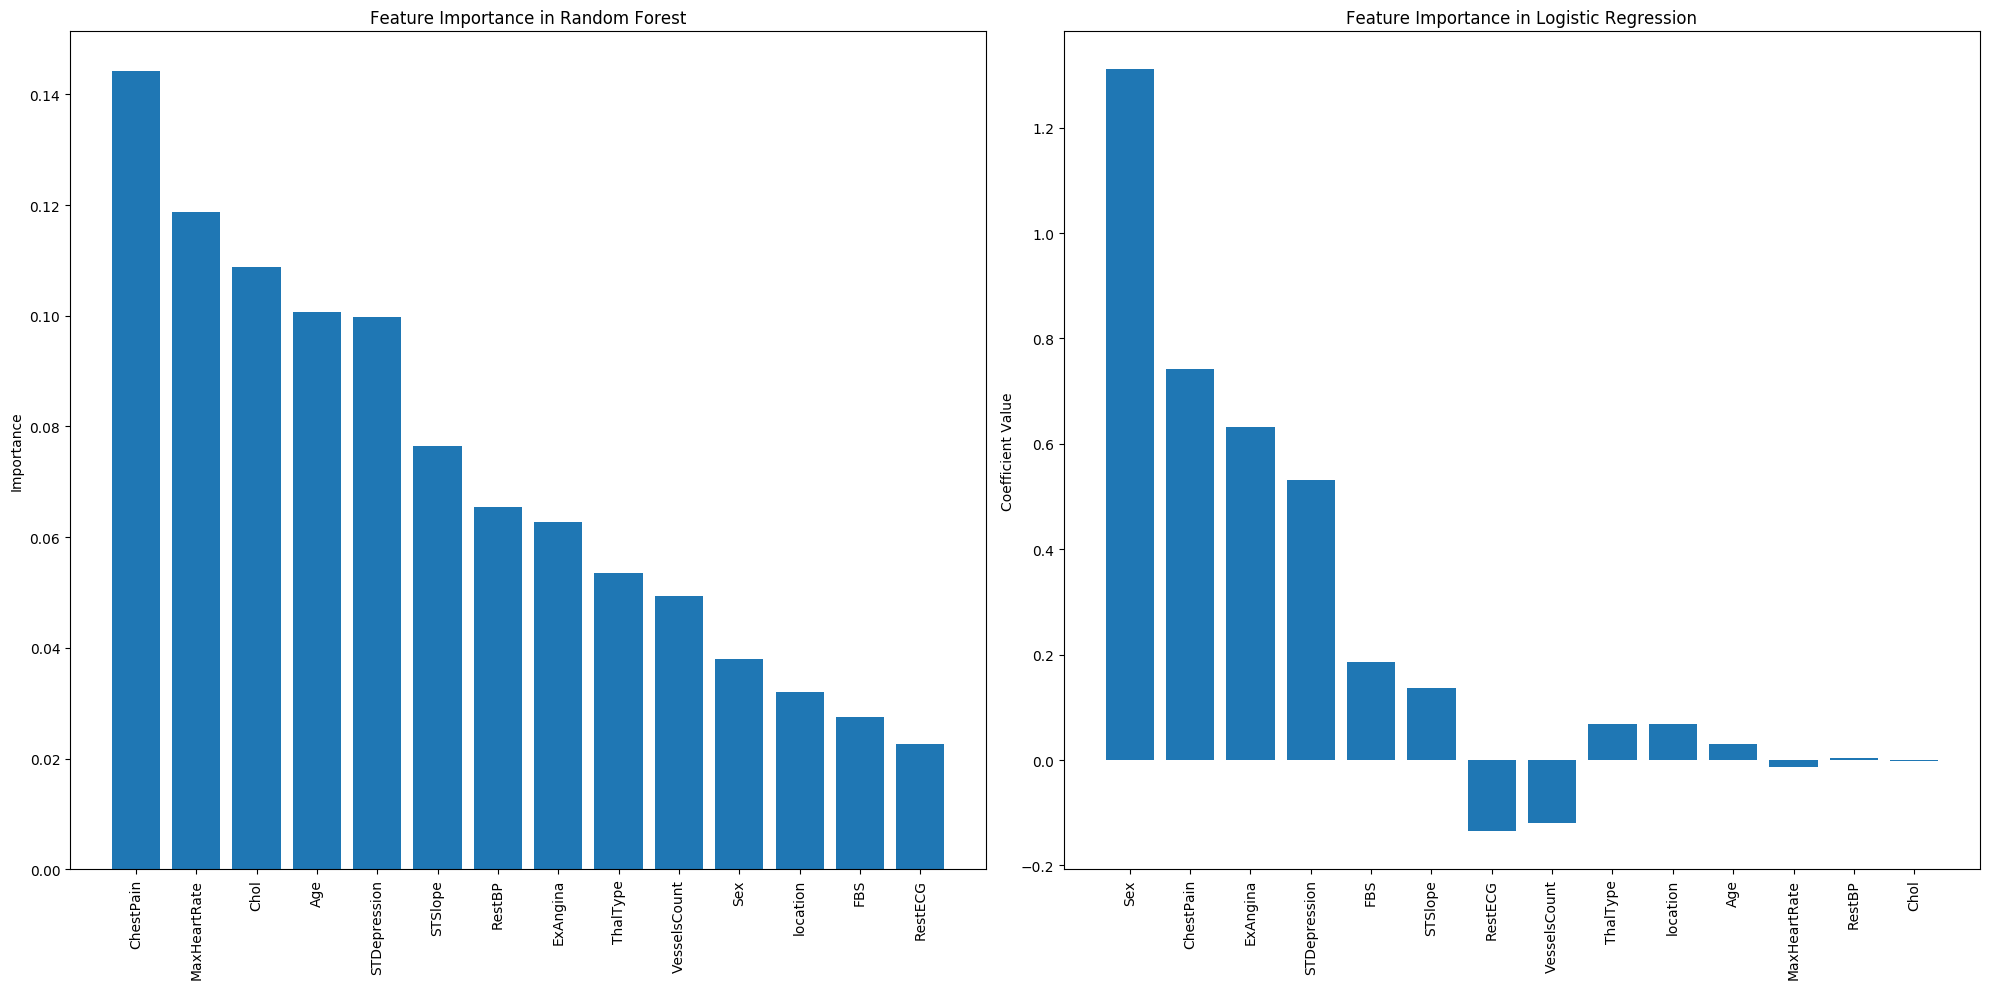

In [ ]:
coefficients = log_reg.coef_[0]
feature_importance = rf_clf.feature_importances_
# Sorting indices for Random Forest
sorted_idx_rf = feature_importance.argsort()[::-1]

# Sorting indices for Logistic Regression
sorted_idx_lr = np.abs(coefficients).argsort()[::-1]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Plot for Random Forest Feature Importance
axes[0].bar(
    range(len(sorted_idx_rf)),
    feature_importance[sorted_idx_rf], align="center"
)
axes[0].set_xticks(range(len(sorted_idx_rf)))
axes[0].set_xticklabels(X.columns[sorted_idx_rf], rotation=90)
axes[0].set_ylabel("Importance")
axes[0].set_title("Feature Importance in Random Forest")

# Plot for Logistic Regression Feature Importance
axes[1].bar(range(len(sorted_idx_lr)),
            coefficients[sorted_idx_lr], align="center")
axes[1].set_xticks(range(len(sorted_idx_lr)))
axes[1].set_xticklabels(X.columns[sorted_idx_lr], rotation=90)
axes[1].set_ylabel("Coefficient Value")
axes[1].set_title("Feature Importance in Logistic Regression")

plt.tight_layout()
plt.show()

`In decision trees and random forests, importance is often calculated based on the number of times a feature is used to split the data and the improvement it brings to the predictions. In Logistic Regression, the magnitude of the coefficients can be seen as an indication of importance, though this is sensitive to feature scaling.`

In [ ]:
# Printing Summary
y_pred_rf = rf_clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(classification_report(y_test, y_pred_rf))

y_pred_leg = log_reg.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_leg)}")
print(classification_report(y_test, y_pred_leg))

Accuracy: 0.8097826086956522
              precision    recall  f1-score   support

           0       0.75      0.72      0.73        67
           1       0.84      0.86      0.85       117

    accuracy                           0.81       184
   macro avg       0.80      0.79      0.79       184
weighted avg       0.81      0.81      0.81       184

Accuracy: 0.8260869565217391
              precision    recall  f1-score   support

           0       0.80      0.70      0.75        67
           1       0.84      0.90      0.87       117

    accuracy                           0.83       184
   macro avg       0.82      0.80      0.81       184
weighted avg       0.82      0.83      0.82       184



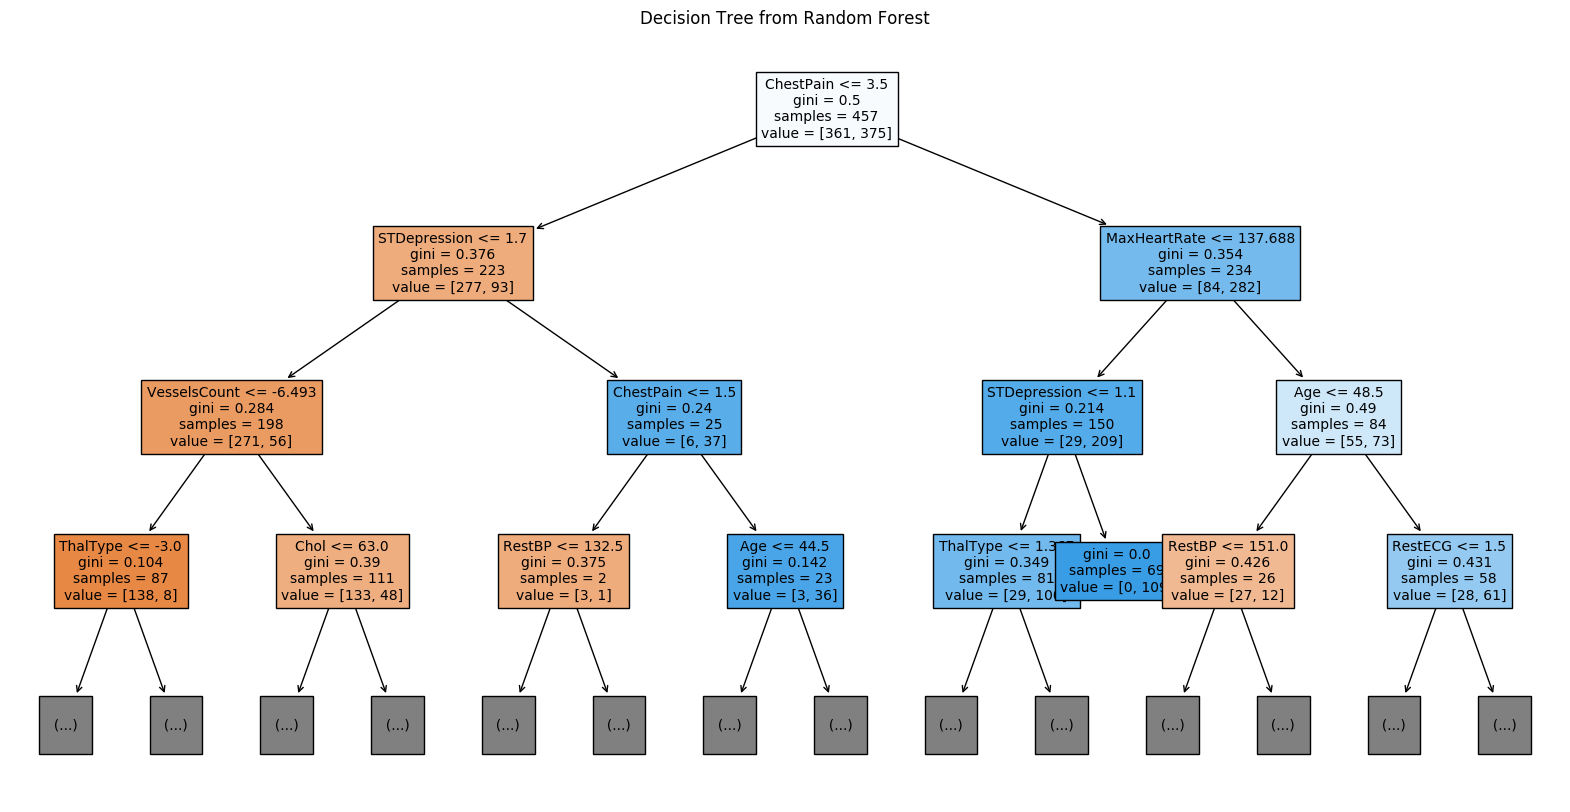

In [ ]:
# RF: tree visualization for Chest Pain
tree = rf_clf.estimators_[3]

plt.figure(figsize=(20, 10))
plot_tree(tree, filled=True, feature_names=X.columns, max_depth=3, fontsize=10)
plt.title("Decision Tree from Random Forest")
plt.show()

In [ ]:
intercept = log_reg.intercept_[0]
coefficients_values = log_reg.coef_[0]

equation_terms_multiline = [
    "\\begin{align*}",
    "\\log\\left(\\frac{{p}}{{1-p}}\\right) &= {:.4f} \\\\".format(intercept),
]

# Adding coefficients and features
for coef, feature in zip(coefficients_values, X.columns):
    sign = "+" if coef >= 0 else "-"
    equation_terms_multiline.append(
        "& {} {:.4f} \\times {} \\\\".format(sign, abs(coef), feature)
    )

# Closing the align* environment
equation_terms_multiline.append("\\end{align*}")

# Joining all terms
final_equation_multiline = "\n".join(equation_terms_multiline)
print("Equation for Logistic Regression")
# Display the final markdown equation string
display(Markdown(final_equation_multiline))

Equation for Logistic Regression


\begin{align*}
\log\left(\frac{p}{1-p}\right) &= -4.3545 \\
& + 0.0310 \times Age \\
& + 1.3105 \times Sex \\
& + 0.7411 \times ChestPain \\
& + 0.0036 \times RestBP \\
& - 0.0013 \times Chol \\
& + 0.1852 \times FBS \\
& - 0.1352 \times RestECG \\
& - 0.0138 \times MaxHeartRate \\
& + 0.6325 \times ExAngina \\
& + 0.5316 \times STDepression \\
& + 0.1365 \times STSlope \\
& - 0.1185 \times VesselsCount \\
& + 0.0692 \times ThalType \\
& + 0.0692 \times location \\
\end{align*}

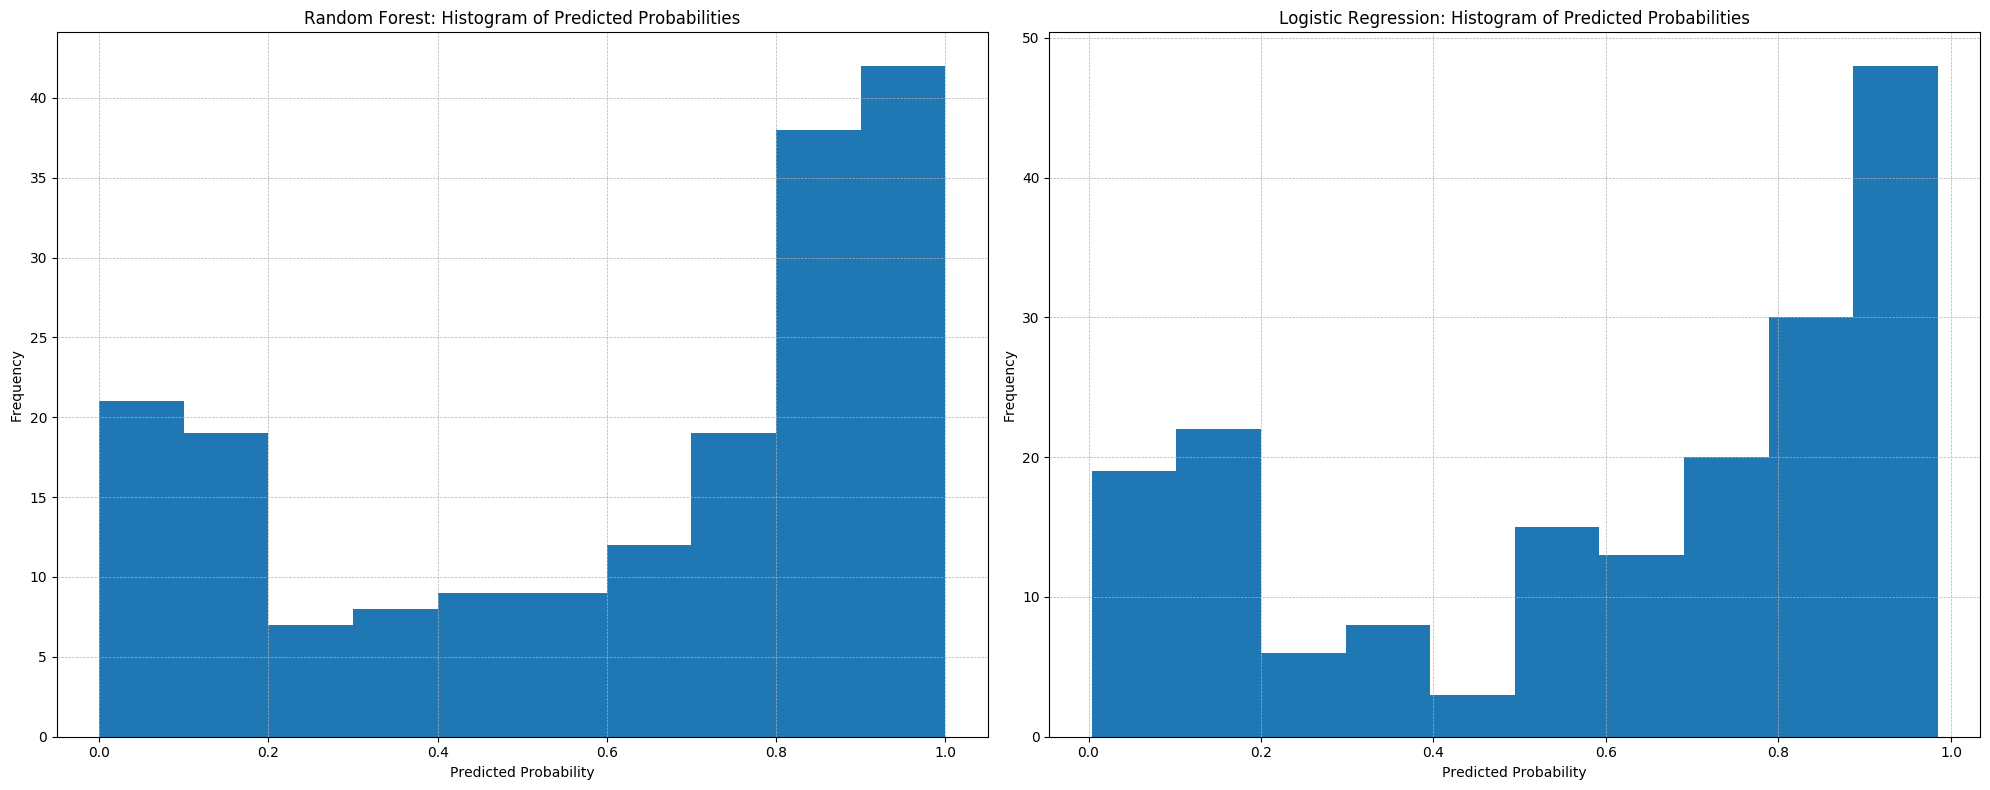

In [ ]:
# Side-by-side comparison of predicted probabilities from Random Forest
# and Logistic Regression
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

# Plot for Random Forest Predicted Probabilities
axes[0].hist(y_score_rf, bins=10)
axes[0].set_xlabel("Predicted Probability")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Random Forest: Histogram of Predicted Probabilities")
axes[0].grid(True, which="both", linestyle="--", linewidth=0.5)

# Plot for Logistic Regression Predicted Probabilities
axes[1].hist(y_score_lr, bins=10)
axes[1].set_xlabel("Predicted Probability")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Logistic Regression: Histogram of Predicted Probabilities")
axes[1].grid(True, which="both", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.show()

TODO: `The Random Forest model seems to be more "confident" in its predictions, providing more extreme probability scores (closer to 0 or 1). In contrast, the Logistic Regression model appears to be more "cautious" or less certain, giving more moderate probability scores.`

#### McFadden's R<sup>2</sup>

In [ ]:
# Computing the log likelihood for the model and for null model
predicted_probs = log_reg.predict_proba(X_test)[:, 1]
log_likelihood_model = np.sum(
    y_test * np.log(predicted_probs) + (1 - y_test) * np.log(1 - predicted_probs)  # noqa: E501
)

prob_positive_class = np.mean(y_test)
log_likelihood_null = np.sum(
    y_test * np.log(prob_positive_class)
    + (1 - y_test) * np.log(1 - prob_positive_class)
)

# McFadden's R^2
r_squared_mcfadden = 1 - (log_likelihood_model / log_likelihood_null)

print(f"McFadden's R^2 for the logistic regression model: ",
      f"{r_squared_mcfadden:.4f}")

McFadden's R^2 for the logistic regression model:  0.3535


## Deep Dive: Questions/Research

Below are some of the trends and patterns that the group expressed interest in.

### Influential Factors in Heart Disease Prediction

*Question: Which physiological and lifestyle variables are most influential in predicting heart disease?*

We will use Stepwise regression to come up with selected variables and then check for the following hypothesis.


| Hypothesis Type | Description                                                                       |
|-----------------|-----------------------------------------------------------------------------------|
| Null Hypothesis (H<sub>0</sub>)  | None of the selected variables have an effect on the disease outcome.             |
| Alternative Hypothesis (H<sub>a</sub>) | At least one of the selected variables has a significant effect on the disease outcome. |



#### Stepwise Regression

In [ ]:
# Stepwise Regression targeting disease (num)

def stepwise_selection(
    X, y, initial_list=[], threshold_in=0.01, threshold_out=0.05, verbose=True
):
    included = list(initial_list)
    while True:
        changed = False
        # Forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(
                y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))
            ).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print(f"{best_feature} with p-value {best_pval:.6}")

        # Backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # Use all coefficients except the intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f"Drop {worst_feature} with p-value {worst_pval:.6}")

        if not changed:
            break

    return included


selected_features_sw = stepwise_selection(X, y)

print(f"selected features: {selected_features_sw}")

ChestPain with p-value 3.74525e-52
STSlope with p-value 5.67432e-22
Sex with p-value 3.76137e-16
MaxHeartRate with p-value 1.04431e-12
ExAngina with p-value 9.62251e-09
STDepression with p-value 2.4982e-06
Chol with p-value 0.00101599
selected features: ['ChestPain', 'STSlope', 'Sex', 'MaxHeartRate', 'ExAngina', 'STDepression', 'Chol']


#### Testing Hypothesis

In [ ]:
results = {}

for feature in selected_features_sw:
    # Defining the null and alternative hypotheses
    # H0: The feature coefficient is 0 (feature does not have any effect)
    # H1: The feature coefficient is not 0 (feature has an effect)

    X_with_const = sm.add_constant(X[feature])
    model = sm.OLS(y, X_with_const).fit()

    coef = model.params[feature]
    p_value = model.pvalues[feature]

    if p_value < 0.05:
        hypothesis_result = "Reject the null hypothesis"
    else:
        hypothesis_result = "Fail to reject the null hypothesis"

    results[feature] = (coef, p_value, hypothesis_result)

# Create a markdown table
result_markdown_table = "| Feature | Coefficient | p-value | Result |\n"
result_markdown_table += (
    "|---------|-------------|---------|-----------------------|\n"  # noqa: E501
)

for feature, (coef, p_value, hypothesis_result) in results.items():
    result_markdown_table += (
        f"| {feature} | {coef:.3f} | {p_value:.3f} | {hypothesis_result} |\n"
    )

# Display the table
display(Markdown(result_markdown_table))

| Feature | Coefficient | p-value | Result |
|---------|-------------|---------|-----------------------|
| ChestPain | 0.252 | 0.000 | Reject the null hypothesis |
| STSlope | 0.047 | 0.000 | Reject the null hypothesis |
| Sex | 0.374 | 0.000 | Reject the null hypothesis |
| MaxHeartRate | -0.007 | 0.000 | Reject the null hypothesis |
| ExAngina | 0.349 | 0.000 | Reject the null hypothesis |
| STDepression | 0.176 | 0.000 | Reject the null hypothesis |
| Chol | -0.001 | 0.000 | Reject the null hypothesis |


### Gender Differences

*Question: Is there a significant difference between males and females within this data in terms of age, blood pressure, cholesterol level, maximum heart rate, ST depression, and other medical indicators?*

Hypotheses:



| Type of Variable | Null Hypothesis (H<sub>0</sub>) | Alternative Hypothesis (H<sub>a</sub>) |
|------------------|---------------------------|----------------------------------|
| Continuous       | The means of the two groups (male and female) for the given continuous variable are equal. | The means of the two groups (male and female) for the given continuous variable are not equal. |
| Categorical      | The distribution of the categorical variable is the same for both groups (male and female). | The distribution of the categorical variable is different between the two groups (male and female). |



In [ ]:
# Split data based on gender for further analysis
female_data = data[data[new_column_names["sex"]] == 0]
male_data = data[data[new_column_names["sex"]] == 1]


# Assuming these are the continuous columns based on the data provided
continuous_columns = ["Age", "RestBP", "Chol", "MaxHeartRate", "STDepression"]
categorical_columns = [
    col for col in data.columns if col not in continuous_columns + ["Sex"]
]


alpha = 0.05

# Start the markdown table with headers
markdown_table = """
| Column Name | Test Type | Test Statistic | P-value | Result |
|-------------|-----------|----------------|---------|--------|
"""

# Statistical tests to identify differences between male and female groups
for col in continuous_columns:
    t_stat, p_val = ttest_ind(female_data[col], male_data[col])
    result = (
        "Reject the null hypothesis"
        if p_val < alpha
        else "Fail to reject the null hypothesis"
    )
    markdown_table += f"| {col} | T-test | {t_stat:.3f} | {p_val:.4f} | {result} |\n"  # noqa: E501

# Chi-square test for categorical variables
for col in categorical_columns:
    contingency_table = pd.crosstab(data["Sex"], data[col])
    chi2, p_val, _, _ = chi2_contingency(contingency_table)
    result = (
        "Reject the null hypothesis"
        if p_val < alpha
        else "Fail to reject the null hypothesis"
    )
    markdown_table += f"| {col} | Chi-square | {chi2:.3f} | {p_val:.4f} | {result} |\n"  # noqa: E501

# Display the markdown table
display(Markdown(markdown_table))


| Column Name | Test Type | Test Statistic | P-value | Result |
|-------------|-----------|----------------|---------|--------|
| Age | T-test | -1.726 | 0.0846 | Fail to reject the null hypothesis |
| RestBP | T-test | -0.497 | 0.6195 | Fail to reject the null hypothesis |
| Chol | T-test | 5.397 | 0.0000 | Reject the null hypothesis |
| MaxHeartRate | T-test | 4.977 | 0.0000 | Reject the null hypothesis |
| STDepression | T-test | -3.129 | 0.0018 | Reject the null hypothesis |
| ChestPain | Chi-square | 37.853 | 0.0000 | Reject the null hypothesis |
| FBS | Chi-square | 19.061 | 0.0003 | Reject the null hypothesis |
| RestECG | Chi-square | 5.539 | 0.2363 | Fail to reject the null hypothesis |
| ExAngina | Chi-square | 45.935 | 0.0000 | Reject the null hypothesis |
| STSlope | Chi-square | 35.441 | 0.0000 | Reject the null hypothesis |
| VesselsCount | Chi-square | 87.636 | 0.0000 | Reject the null hypothesis |
| ThalType | Chi-square | 122.746 | 0.0000 | Reject the null hypothesis |
| HeartDisease | Chi-square | 87.840 | 0.0000 | Reject the null hypothesis |
| location | Chi-square | 80.848 | 0.0000 | Reject the null hypothesis |


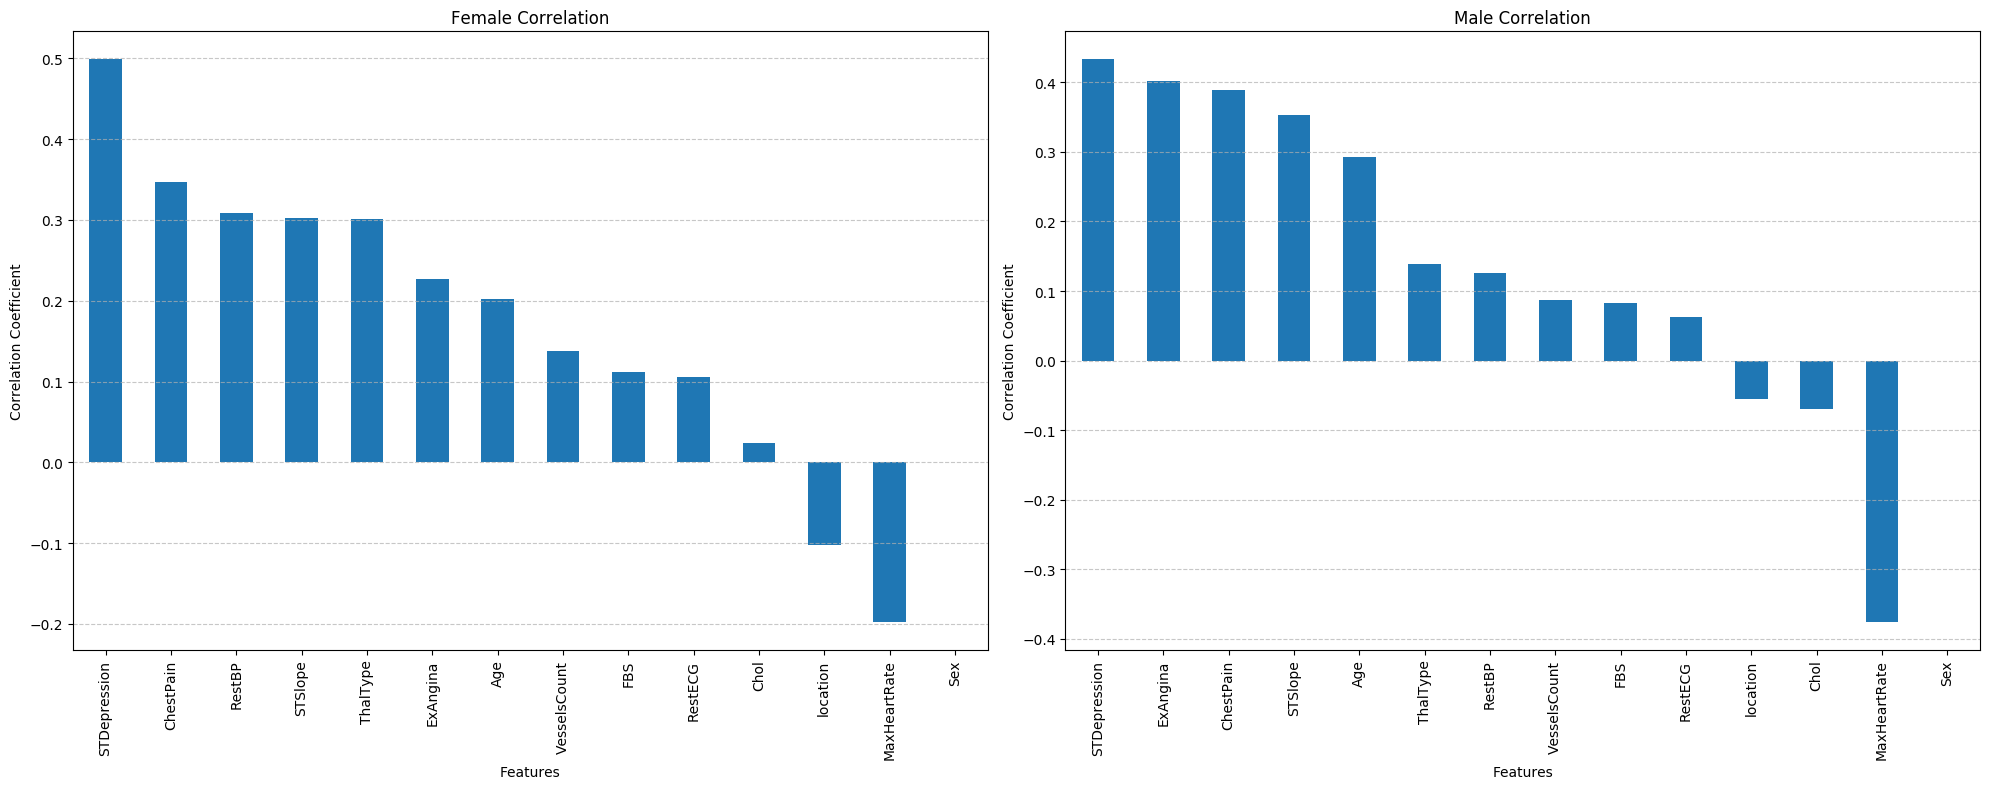

In [ ]:
# Visualizing The Finding
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

plot_correlation_against_y(female_data, ax=axes[0], Note="Female Correlation")
plot_correlation_against_y(male_data, ax=axes[1], Note="Male Correlation")

plt.tight_layout()
plt.show()

### Chest Pain as a Predictor

*Question: Does chest pain significantly predict the risk of heart disease?*


Hypotheses:

| Hypothesis Type | Description                                                                                                    |
|-----------------|----------------------------------------------------------------------------------------------------------------|
| H<sub>0</sub>       | Chest pain has no significant impact on disease outcome and therefore cannot be an accurate predictor of disease risk. |
| H<sub>a</sub>     | Chest pain has a significant impact on disease outcome and can therefore be an accurate predictor of disease risk.      |


In [ ]:
# Checking significance of Chest Pain as a predictor using Logistic Regression
X_with_const = sm.add_constant(X[new_column_names['cp']])
model = sm.Logit(y, X_with_const)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.567867
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           HeartDisease   No. Observations:                  920
Model:                          Logit   Df Residuals:                      918
Method:                           MLE   Df Model:                            1
Date:                Sun, 22 Oct 2023   Pseudo R-squ.:                  0.1740
Time:                        10:53:41   Log-Likelihood:                -522.44
converged:                       True   LL-Null:                       -632.47
Covariance Type:            nonrobust   LLR p-value:                 8.788e-50
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.7151      0.318    -11.695      0.000      -4.338      -3.092
ChestPain      1.2032      0.

Reject the null hypothesis that chest pain has no significant impact on disease outcome and therefore cannot be an accurate predictor of heart disease

### Missing Value Check

*Does the method of handling missing values in a dataset significantly alter the distribution of the respective features?*

For each column with missing values, the hypotheses will be applied as follows:

| Hypothesis | Description |
|------------|-------------|
| H<sub>0</sub>    | The distribution of the feature remains the same after handling missing values. |
| H<sub>a</sub>    | The distribution of the feature changes significantly after handling missing values. |

In [ ]:
# Perform KS test for a column after handling missing values
def ks_test_for_column(column_data, method):
    # Remove rows with missing values
    if method == "remove":
        cleaned_data = column_data.dropna().astype(float)
    # Replace with mean
    elif method == "mean":
        cleaned_data = column_data.fillna(column_data.dropna().astype(float).mean())  # noqa: E501
    # Replace with median
    elif method == "median":
        cleaned_data = column_data.fillna(column_data.dropna().astype(float).median())  # noqa: E501
    # Replace with mode
    elif method == "mode":
        mode_val = column_data.dropna().astype(float).mode().iloc[0]
        cleaned_data = column_data.fillna(mode_val)
    else:
        return None

    cleaned_data = cleaned_data.astype(float)
    original_data = column_data[column_data != "?"].astype(float)

    # Perform KS test
    statistic, p_value = ks_2samp(original_data, cleaned_data)

    return statistic, p_value


# Summary table
results = []

unclean_data.replace("?", pd.NA, inplace=True)
columns_with_missing_values = unclean_data.columns[
    unclean_data.isnull().any()
].to_list()

# Iterate over each column with missing values
for col in columns_with_missing_values:
    for method in ["remove", "mean", "median", "mode"]:
        stat, p_val = ks_test_for_column(unclean_data[col], method)
        decision = "Reject H0" if p_val < 0.05 else "Fail to Reject H0"
        results.append([col, method, stat, p_val, decision])

# Convert to DataFrame for better visualization
results_df = pd.DataFrame(
    results, columns=["Feature", "Method",
                      "Test Statistic", "P-value", "Decision"]
)

results_df

,Feature,Method,Test Statistic,P-value,Decision
0,trestbps,remove,0.063043,5.490098e-02,Fail to Reject H0
1,trestbps,mean,0.063043,5.162100e-02,Fail to Reject H0
2,trestbps,median,0.063043,5.162100e-02,Fail to Reject H0
3,trestbps,mode,0.063043,5.162100e-02,Fail to Reject H0
4,chol,remove,0.007609,1.000000e+00,Fail to Reject H0
5,chol,mean,0.007609,1.000000e+00,Fail to Reject H0
6,chol,median,0.007609,1.000000e+00,Fail to Reject H0
7,chol,mode,0.007609,1.000000e+00,Fail to Reject H0
8,fbs,remove,0.089130,1.729412e-03,Reject H0
9,fbs,mean,0.089130,1.331739e-03,Reject H0


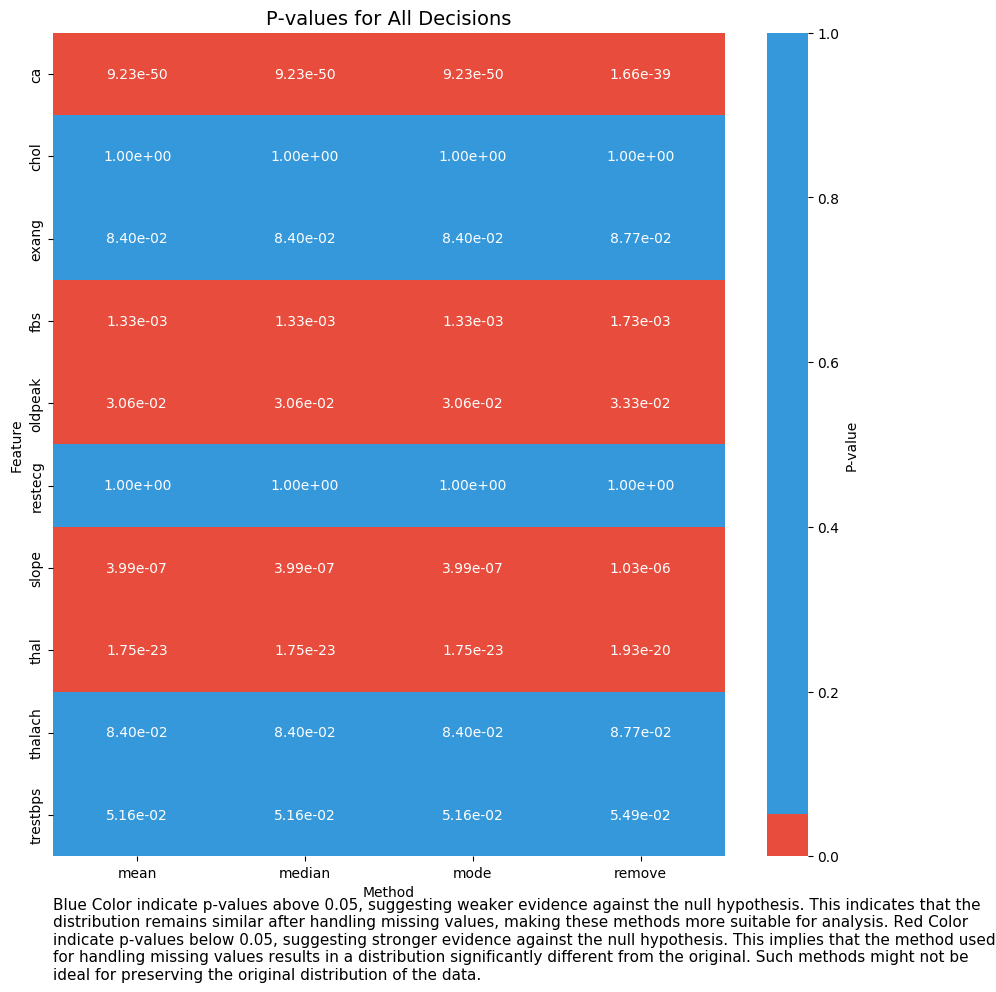

In [ ]:
heatmap_df_all_pvalues = results_df.pivot(
    index="Feature", columns="Method", values="P-value"
)


# Adjusted Title and Description based on switched colors
title = "P-values for All Decisions"
description = "Blue Color indicate p-values above 0.05, suggesting weaker evidence against the null hypothesis. This indicates that the distribution remains similar after handling missing values, making these methods more suitable for analysis. Red Color indicate p-values below 0.05, suggesting stronger evidence against the null hypothesis. This implies that the method used for handling missing values results in a distribution significantly different from the original. Such methods might not be ideal for preserving the original distribution of the data."  # noqa: E501

# Adjust the colormap to have two distinct colors:
# one for values below 0.05 and another for values above 0.05
cmap = ["#e74c3c", "#3498db"]

# Create a custom colormap based on the defined breakpoints
colors = ListedColormap(cmap)

# Visualization with binary colormap
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    heatmap_df_all_pvalues,
    cmap=colors,
    annot=True,
    fmt=".2e",
    center=0.05,
    cbar_kws={"label": "P-value"},
    ax=ax,
)

ax.set_title(title, fontsize=14)
ax.text(
    0,
    -0.05,
    description,
    ha="left",
    va="top",
    wrap=True,
    transform=ax.transAxes,
    fontsize=11,
)

plt.tight_layout()
plt.show()